In [71]:
# example output
import fsspec
import xarray as xr
from xarrayutils.plotting import linear_piecewise_scale
from dask.diagnostics import ProgressBar

zarr_data_path = 'gs://leap-persistent/jbusecke/ocean_emulators/OM4/OM4_raw_test.zarr'
nc_grid_path = 'gs://leap-persistent/sd5313/OM4-5daily/ocean_static_no_mask_table.nc'

ds_raw = xr.open_dataset(zarr_data_path, engine='zarr', chunks={})

with fsspec.open(nc_grid_path) as f:
    ds_grid = xr.open_dataset(f).load().drop_vars('time')
ds_grid = ds_grid.set_coords(ds_grid.data_vars)

# from https://github.com/m2lines/ocean_emulators/issues/17
dz = xr.DataArray(
    [
        5,
        10,
        15,
        20,
        30,
        50,
        70,
        100,
        150,
        200,
        250,
        300,
        400,
        500,
        600,
        800,
        1000,
        1000,
        1000,
    ],
    dims=["lev"],
)


ds = xr.merge([ds_raw, ds_grid]).assign_coords(dz=dz)
ds

<xarray.Dataset> Size: 2TB
Dimensions:       (lev: 19, nv: 2, time: 4745, xh: 1440, xq: 1441, yh: 1080,
                   yq: 1081)
Coordinates: (12/35)
  * lev           (lev) float64 152B 2.5 10.0 22.5 40.0 ... 4e+03 5e+03 6e+03
  * nv            (nv) float64 16B 1.0 2.0
  * time          (time) object 38kB 1958-01-03 12:00:00 ... 2022-12-29 12:00:00
  * xh            (xh) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * xq            (xq) float64 12kB -299.8 -299.6 -299.3 ... 59.66 59.91 60.16
  * yh            (yh) float64 9kB -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
    ...            ...
    dyCv          (yq, xh) float32 6MB nan nan nan nan ... 246.8 148.7 49.76
    areacello_cu  (yh, xq) float32 6MB nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    areacello_cv  (yq, xh) float32 6MB nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    areacello_bu  (yq, xq) float32 6MB nan nan nan ... 1.203e+06 4.55e+05
    basin         (yh, xh) int32 6MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz            (lev) int64 152B 5 10 15 20 30 50 ... 600 800 1000 1000 1000
Data variables:
    hfds          (time, yh, xh) float32 30GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
    so            (time, lev, yh, xh) float32 561GB dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    tauuo         (time, yh, xq) float32 30GB dask.array<chunksize=(1, 1080, 1441), meta=np.ndarray>
    tauvo         (time, yq, xh) float32 30GB dask.array<chunksize=(1, 1081, 1440), meta=np.ndarray>
    thetao        (time, lev, yh, xh) float32 561GB dask.array<chunksize=(1, 19, 1080, 1440), meta=np.ndarray>
    time_bnds     (time, nv) object 76kB dask.array<chunksize=(1500, 2), meta=np.ndarray>
    uo            (time, lev, yh, xq) float32 561GB dask.array<chunksize=(1, 19, 1080, 1441), meta=np.ndarray>
    vo            (time, lev, yq, xh) float32 561GB dask.array<chunksize=(1, 19, 1081, 1440), meta=np.ndarray>
    zos           (time, yh, xh) float32 30GB dask.array<chunksize=(1, 1080, 1440), meta=np.ndarray>
Attributes:
    associated_files:  areacello: 19580101.ocean_static.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             OM4p25_5daily_cycle1

In [72]:
# Prediction data
ds_pred = xr.open_dataset('gs://leap-persistent/sd5313/convnext_bestepoch-28_train-OM4v0.2.1_eval-OM4v0.2.1', engine='zarr', chunks={})
ds_pred = ds_pred.rename({'x': 'xh', 'y': 'yh'})
ds_pred

# Associated ground truth data
ls = ['thetao','so']
ds = ds.isel(time=slice(4143, 4743))
ds = ds[ls]
ds_pred = ds_pred[ls]

In [73]:
# Testing
ds = ds.isel(time=slice(0, 40))
ds_pred = ds_pred.isel(time=slice(0, 40))

In [74]:
def profile_mean(ds: xr.Dataset) -> xr.Dataset:
    return ds.weighted(ds.areacello).mean(["xh", "yh"])

def profile_std(ds: xr.Dataset) -> xr.Dataset:
    return ds.weighted(ds.areacello).std(["xh", "yh"])

def full_std(ds: xr.Dataset) -> xr.Dataset:
    return ds.weighted(ds.areacello*ds.dz).std(["xh", "yh", "lev"]).mean("time")

In [75]:
with ProgressBar():
    profile_prediction = profile_mean(ds_pred).load()
    profile_groundtruth = profile_mean(ds).load()
    profile_stdv_prediction = profile_std(ds_pred).load()
    profile_stdv_groundtruth = profile_std(ds).load()
    stdv_groundtruth = full_std(ds).load()

[########################################] | 100% Completed | 405.91 ms
[########################################] | 100% Completed | 5.17 ss
[########################################] | 100% Completed | 612.73 ms
[########################################] | 100% Completed | 6.34 ss
[########################################] | 100% Completed | 10.60 s


In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
var_list = {
        "vo": r"$v$ $( m/s )$",
        "uo": r"$u$ $( m/s )$",
        "thetao": r"$T$ $( ^\circ C )$",
        "so": r"$so$ $( psu )$",
        "zos": r"$zos$ $( m )$",
        "KE": r"$KE$ $( J/m^2 )$",
    }

def adjust_depth(ax):
    # todo make split vertical axes
    linear_piecewise_scale(1000, 5, ax=ax)
    # indicate the point between the different scalings
    ax.axhline(1000, color="0.5", ls="--")
    # Rearange the yticks
    ax.set_yticks([0, 250, 500, 750, 1000, 3000, 5000])
    

In [78]:
import matplotlib.colors as colors
import math    

def plot_depth_profile(data, title=""):
    plt.clf()
    plt.rcParams.update({'font.size': 14})
    vmax = stdv_groundtruth[title.split(" ")[0]]
    gsp = math.ceil(-math.log10(vmax))
    lsp=gsp+4
    gain = 10**(-gsp)
    lnrwidth = 10**(3-lsp)
    # print(vmax, gsp, lsp, gain, lnrwidth)
    levels = [-k * 10**-i for i in range(gsp, lsp+1) for k in [5, 1]][1:] + [k*10**-i for i in range(lsp, gsp-1, -1) for k in [1, 5]][:-1] # [-1 * 10**-i for i in range(gsp, lsp+1)] + [10**-i for i in range(lsp, gsp-1, -1)]
    # print(title, gain, lnrwidth, levels)

    norm = colors.SymLogNorm(linthresh=lnrwidth, linscale=0.25, vmin=-2*gain, vmax=2*gain, base=10)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    pcm = data.plot(
        x="time",
        yincrease=False,
        levels=levels,
        norm=norm,
        cmap='RdBu_r',
        add_colorbar=False,
        ax=ax
    )

    # Adding the colorbar with custom ticks
    cbar = plt.colorbar(pcm, ax=ax, extend='neither')
    cbar.set_label(var_list[title.split(" ")[0]])

    # Adjust the plot
    adjust_depth(ax)
    plt.title(title)
    plt.show()

<Figure size 640x480 with 0 Axes>

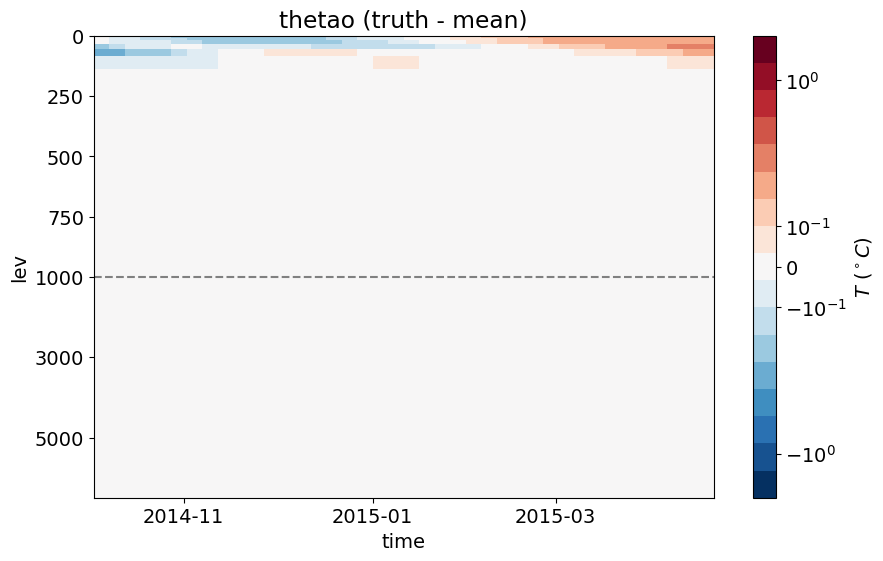

<Figure size 640x480 with 0 Axes>

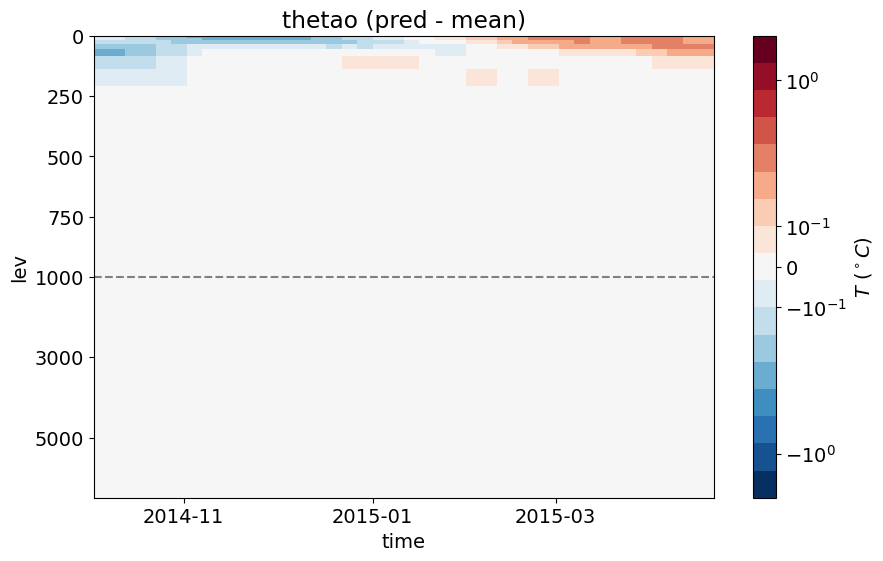

<Figure size 640x480 with 0 Axes>

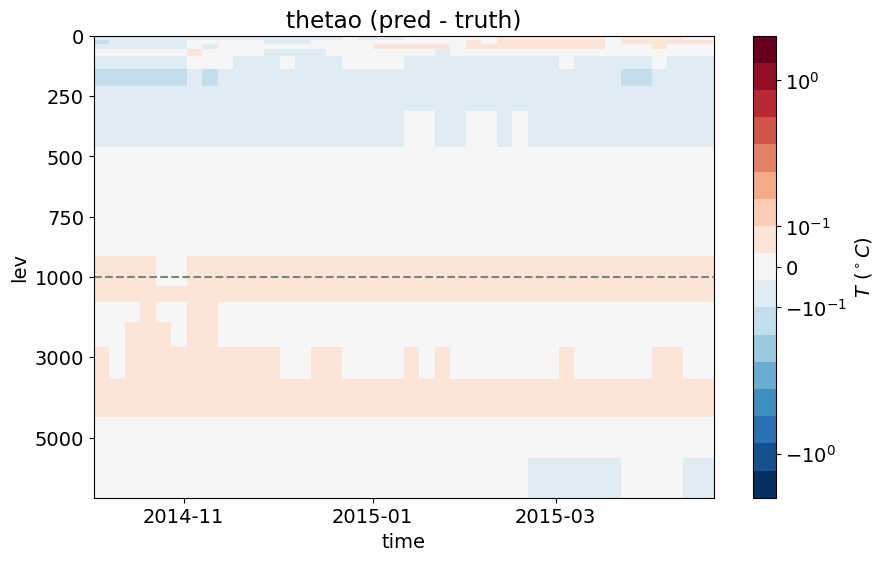

<Figure size 640x480 with 0 Axes>

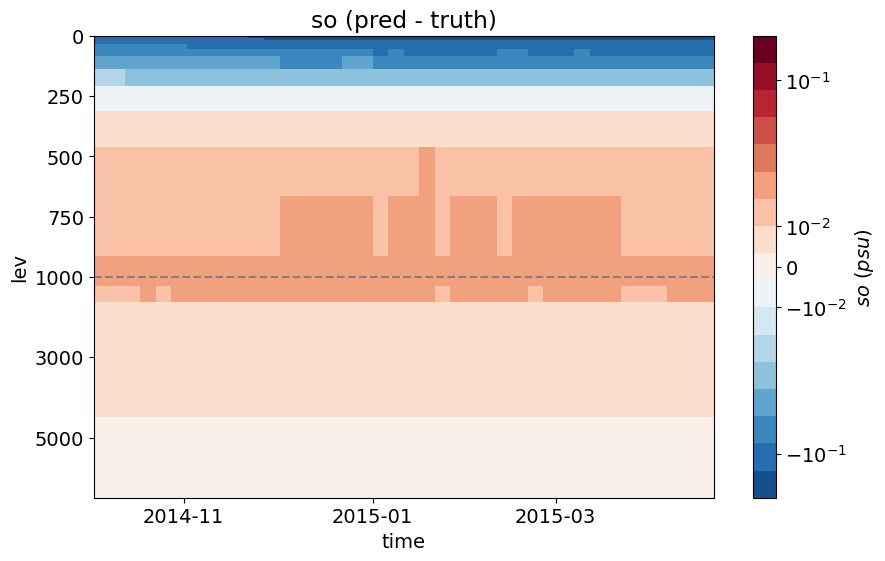

In [80]:
plot_depth_profile(((profile_groundtruth - profile_groundtruth.mean("time"))).thetao, title=f"thetao (truth - mean)")
plot_depth_profile(((profile_prediction - profile_prediction.mean("time"))).thetao, title=f"thetao (pred - mean)")
for v in ls:
    plot_depth_profile((profile_prediction - profile_groundtruth)[v], title=f"{v} (pred - truth)")

thetao


<Figure size 640x480 with 0 Axes>

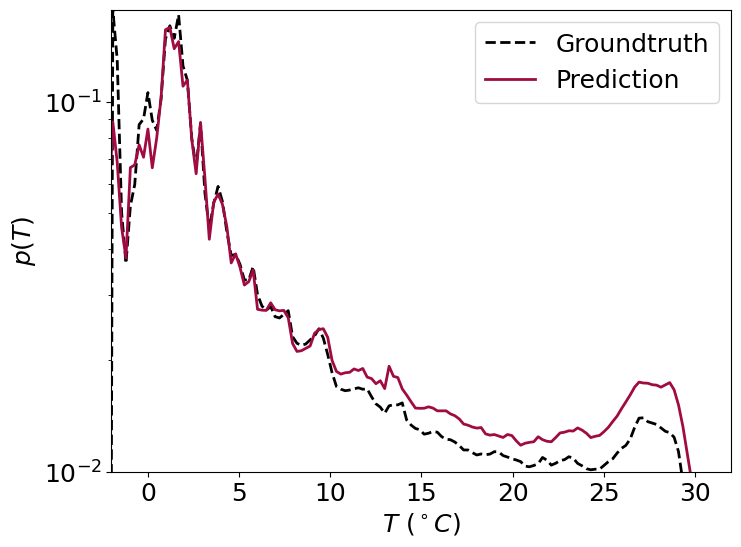

so


<Figure size 640x480 with 0 Axes>

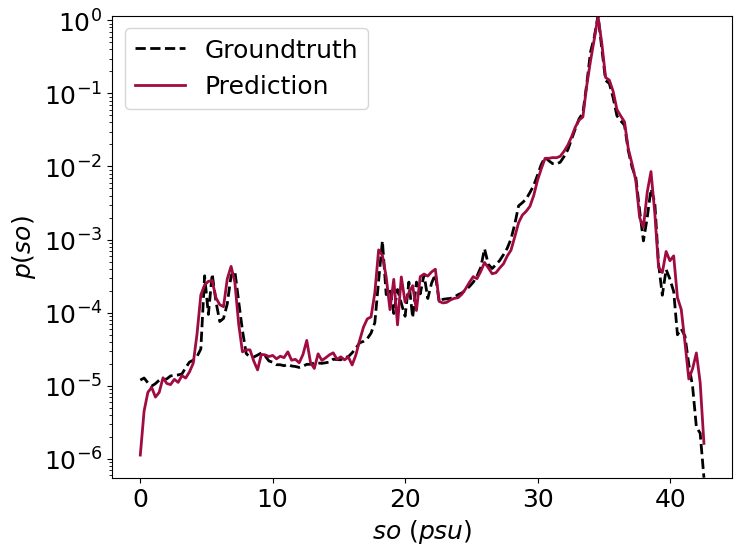

In [87]:
import numpy as np
for v in ls:
    print(v)
    plt.clf()
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=[8, 6])
    min, max = ds[v].min().values, ds[v].max().values
    true_pdf, bins_true = np.histogram(ds[v], bins=150, density=True, range=(min, max))
    pdf_net, bins_net = np.histogram(ds_pred[v], bins=bins_true, density=True, range=(min, max))
    plt.semilogy(bins_true[:-1], true_pdf, label="Groundtruth", color='k', lw=2, ls='--')
    plt.semilogy(bins_net[:-1], pdf_net, label="Prediction", color='#A00B41', lw=2)
    plt.legend()
    plt.xlabel(var_list[v])
    plt.ylabel(r"${p(}$" + var_list[v].split(" $")[0] + "${)}$")
    if v != 'thetao':
        plt.ylim(
            [
                true_pdf.min(),
                true_pdf.max(),
            ]
        )
        if v == 'KE':
            plt.xlim([0, 2500])
    else:
        plt.ylim(
            [
                0.01,
                true_pdf.max(),
            ]
        )
        plt.xlim([-2, 32])
    plt.show()